# 02 — Data Understanding (Kedro + CRISP-DM)

In [1]:
# --- Inicializar Kedro sin magics ---
from pathlib import Path
from kedro.framework.session import KedroSession
from kedro.framework.startup import bootstrap_project

# localizar la raíz del proyecto subiendo hasta encontrar pyproject.toml
project_path = Path.cwd()
while project_path != project_path.parent and not (project_path / "pyproject.toml").exists():
    project_path = project_path.parent
assert (project_path / "pyproject.toml").exists(), f"No encuentro pyproject.toml desde {Path.cwd()}"

bootstrap_project(str(project_path))
session = KedroSession.create(project_path=str(project_path))
ctx = session.load_context()
catalog = ctx.catalog

print("Proyecto:", project_path)

[09/15/25 22:17:25] INFO     Using                                                                  ]8;id=507947;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\framework\project\__init__.py\__init__.py]8;;\:]8;id=57658;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\framework\project\__init__.py#270\270]8;;\
                             'c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\framework                
                             \project\rich_logging.yml' as logging configuration.                                  

[09/15/25 22:17:27] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=997573;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=46001;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

Proyecto: c:\Users\lttlk\Documents\Nueo\machinegame


In [2]:
# Diagnóstico rápido
import sys
try:
    import kedro
    print("Python:", sys.executable)
    print("Kedro:", kedro.__version__)
    print("Datasets (primeros 15):", list(catalog.list())[:15])
except Exception as e:
    print("No se pudo inspeccionar kedro:", e)

Python: c:\Users\lttlk\Documents\Nueo\.venv\Scripts\python.exe
Kedro: 1.0.0
No se pudo inspeccionar kedro: 'DataCatalogWithCatalogCommandsMixin' object has no attribute 'list'


In [3]:
# Helpers: cargar o reconstruir y reparación de encoding
from pathlib import Path
import pandas as pd

def load_or_build(name: str, pipe: str):
    """Intenta catalog.load(name); si falla, ejecuta el pipeline y vuelve a cargar."""
    try:
        return catalog.load(name)
    except Exception as e:
        print(f"[load_or_build] {name} no disponible o ilegible ({e}). Corriendo pipeline: {pipe} …")
        session.run(pipeline_name=pipe)
        return catalog.load(name)

def fix_reporting_csv_encoding(report_dir: Path | str = None, encoding_from: str = "latin1", encoding_to: str = "utf-8"):
    """Repara CSVs en 08_reporting que estén en ANSI/latin-1: reescribe en UTF-8.
    Si ya son UTF-8 válidos, los deja intactos.
    """
    if report_dir is None:
        report_dir = project_path / "data" / "08_reporting"
    report_dir = Path(report_dir)
    if not report_dir.exists():
        print("[fix_reporting_csv_encoding] No existe la carpeta:", report_dir)
        return

    fixed, skipped = [], []
    for p in report_dir.glob("*.csv"):
        try:
            _ = pd.read_csv(p, encoding=encoding_to, nrows=5)
            skipped.append(p.name)
        except Exception:
            try:
                df = pd.read_csv(p, encoding=encoding_from)
                df.to_csv(p, index=False, encoding=encoding_to)
                fixed.append(p.name)
            except Exception as e:
                print(f"[fix_reporting_csv_encoding] No se pudo reparar {p.name}: {e}")
    print("[fix_reporting_csv_encoding] Reparados (latin-1 -> utf-8):", fixed)
    print("[fix_reporting_csv_encoding] Ya estaban en utf-8:", skipped)

### Ejecutar pipeline de Data Understanding

In [4]:
session.run(pipeline_name="data_understanding")

[09/15/25 22:17:43] INFO     Kedro project machinegame                                               ]8;id=45022;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\framework\session\session.py\session.py]8;;\:]8;id=209808;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\framework\session\session.py#330\330]8;;\

                    INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=693936;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=221365;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

[09/15/25 22:17:44] WARNING  Workflow tracking is disabled during partial pipeline runs (executed  ]8;id=670460;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro_viz\integrations\kedro\run_hooks.py\run_hooks.py]8;;\:]8;id=584413;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro_viz\integrations\kedro\run_hooks.py#135\135]8;;\
                             using --from-nodes, --to-nodes, --tags, --pipeline, and more).                        
                             `.viz/kedro_pipeline_events.json` will be created only during a full                  
                             kedro run. See issue                                                                  
                             https://github.com/kedro-org/kedro-viz/issues/2443 for more details.                  

                    INFO     Using synchronous mode for loading and saving data. Use the    ]8;id=440401;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\sequential_runner.py\sequential_runner.py]8;;\:]8;id=945850;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\sequential_runner.py#59\59]8;;\
                             --async flag for potential performance gains.                                         
                             https://docs.kedro.org/en/stable/nodes_and_pipelines/run_a_pip                        
                             eline.html#load-and-save-asynchronously                                               

                    INFO     Loading data from params:business.objectives (MemoryDataset)...   ]8;id=946941;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=45772;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from params:business.questions (MemoryDataset)...    ]8;id=971267;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=770929;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from params:business.success_metrics                 ]8;id=491101;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=766049;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\
                             (MemoryDataset)...                                                                    

                    INFO     Running node: business_report_node: build_business_report() ->             ]8;id=9611;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\pipeline\node.py\node.py]8;;\:]8;id=895700;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\pipeline\node.py#420\420]8;;\

                    INFO     Saving data to business_report (CSVDataset)...                    ]8;id=622837;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=873324;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1006\1006]8;;\

                    INFO     Completed node: business_report_node                                     ]8;id=948406;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py\runner.py]8;;\:]8;id=992657;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py#245\245]8;;\

                    INFO     Completed 1 out of 2 tasks                                               ]8;id=266265;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py\runner.py]8;;\:]8;id=653282;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py#246\246]8;;\

                    INFO     Loading data from params:paths.games_raw (MemoryDataset)...       ]8;id=841559;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=398865;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from params:paths.steam_raw (MemoryDataset)...       ]8;id=809478;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=126015;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from params:paths.vg_sales_raw (MemoryDataset)...    ]8;id=630111;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=211517;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Running node: dataset_inventory_node: inventory_raw_datasets() ->          ]8;id=414989;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\pipeline\node.py\node.py]8;;\:]8;id=246551;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\pipeline\node.py#420\420]8;;\

                    INFO     Saving data to dataset_inventory (CSVDataset)...                  ]8;id=342119;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=946220;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1006\1006]8;;\

                    INFO     Completed node: dataset_inventory_node                                   ]8;id=903529;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py\runner.py]8;;\:]8;id=373838;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py#245\245]8;;\

                    INFO     Completed 2 out of 2 tasks                                               ]8;id=291742;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py\runner.py]8;;\:]8;id=795332;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py#246\246]8;;\

                    INFO     Pipeline execution completed successfully in 0.1 sec.                    ]8;id=247241;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py\runner.py]8;;\:]8;id=53893;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\runner\runner.py#119\119]8;;\


{
    'dataset_inventory': kedro_datasets.pandas.csv_dataset.CSVDataset(filepath=PurePosixPath('C:/Users/lttlk/Documents/Nueo/machinegame/data/08_reporting/dataset_inventory.csv'), protocol='file', load_args={'encoding': 'utf-8'}, save_args={'index': False, 'encoding': 'utf-8'}),
    'business_report': kedro_datasets.pandas.csv_dataset.CSVDataset(filepath=PurePosixPath('C:/Users/lttlk/Documents/Nueo/machinegame/data/08_reporting/business_understanding.csv'), protocol='file', load_args={'encoding': 'utf-8'}, save_args={'index': False, 'encoding': 'utf-8'})
}

### Reparar encoding de reporting (si fuese necesario)

In [5]:
fix_reporting_csv_encoding()

[fix_reporting_csv_encoding] Reparados (latin-1 -> utf-8): ['business_understanding.csv']
[fix_reporting_csv_encoding] Ya estaban en utf-8: ['dataset_inventory.csv', 'eda_summary.csv', 'games_describe.csv', 'steam_describe.csv', 'vg_sales_describe.csv']


### Cargar artefactos EDA

In [6]:
eda_summary = load_or_build("eda_summary", "data_understanding")
games_desc = load_or_build("games_describe", "data_understanding")
steam_desc = load_or_build("steam_describe", "data_understanding")
vg_desc = load_or_build("vg_sales_describe", "data_understanding")
display(eda_summary)
display(games_desc.head(20))
display(steam_desc.head(20))
display(vg_desc.head(20))

[09/15/25 22:17:51] INFO     Loading data from eda_summary (CSVDataset)...                     ]8;id=948527;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=78934;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from games_describe (CSVDataset)...                  ]8;id=514198;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=824574;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from steam_describe (CSVDataset)...                  ]8;id=554868;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=955123;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from vg_sales_describe (CSVDataset)...               ]8;id=668418;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=268342;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

,dataset,filas,columnas,nulos_totales
0,games,14801,4,0
1,steam,199999,5,0
2,vg_sales,16719,16,49141


,dataset,columna,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,data/01_raw/Games.csv,Console,14801.0,139.0,PC,4182.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data/01_raw/Games.csv,GameName,14801.0,11256.0,Open Season Review,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data/01_raw/Games.csv,Review,14801.0,11.0,Good,4118.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data/01_raw/Games.csv,Score,14801.0,NaN,NaN,NaN,6.429498,1.611753,1.0,6.0,7.0,8.0,9.0


,dataset,columna,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,data/01_raw/steam-200k.csv,151603712,199999.0,NaN,NaN,NaN,1.036556e+08,7.208084e+07,5250.0,47384202.0,86912006.0,154230933.0,309903146.0
1,data/01_raw/steam-200k.csv,The Elder Scrolls V Skyrim,199999.0,5155.0,Dota 2,9682.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data/01_raw/steam-200k.csv,purchase,199999.0,2.0,purchase,129510.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,data/01_raw/steam-200k.csv,1.0,199999.0,NaN,NaN,NaN,1.787447e+01,1.380573e+02,0.1,1.0,1.0,1.3,11754.0
4,data/01_raw/steam-200k.csv,0,199999.0,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0


,dataset,columna,count,unique,top,freq,mean,std,min,25%,50%,75%,max
0,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,Name,16717.0,11562.0,Need for Speed: Most Wanted,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,Platform,16719.0,31.0,PS2,2161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,Year_of_Release,16450.0,NaN,NaN,NaN,2006.487356,5.878995,1980.00,2003.00,2007.00,2010.00,2020.00
3,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,Genre,16717.0,12.0,Action,3370.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,Publisher,16665.0,582.0,Electronic Arts,1356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,NA_Sales,16719.0,NaN,NaN,NaN,0.263330,0.813514,0.00,0.00,0.08,0.24,41.36
6,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,EU_Sales,16719.0,NaN,NaN,NaN,0.145025,0.503283,0.00,0.00,0.02,0.11,28.96
7,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,JP_Sales,16719.0,NaN,NaN,NaN,0.077602,0.308818,0.00,0.00,0.00,0.04,10.22
8,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,Other_Sales,16719.0,NaN,NaN,NaN,0.047332,0.186710,0.00,0.00,0.01,0.03,10.57
9,data/01_raw/Video_Games_Sales_as_at_22_Dec_201...,Global_Sales,16719.0,NaN,NaN,NaN,0.533543,1.547935,0.01,0.06,0.17,0.47,82.53


### Vistas rápidas (matplotlib puro; no seaborn, sin estilos)

[09/15/25 22:18:00] INFO     Loading data from games_raw (CSVDataset)...                       ]8;id=103090;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=655656;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from steam_raw (CSVDataset)...                       ]8;id=190115;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=974914;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

                    INFO     Loading data from vg_sales_raw (CSVDataset)...                    ]8;id=812652;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=978837;file://c:\Users\lttlk\Documents\Nueo\.venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

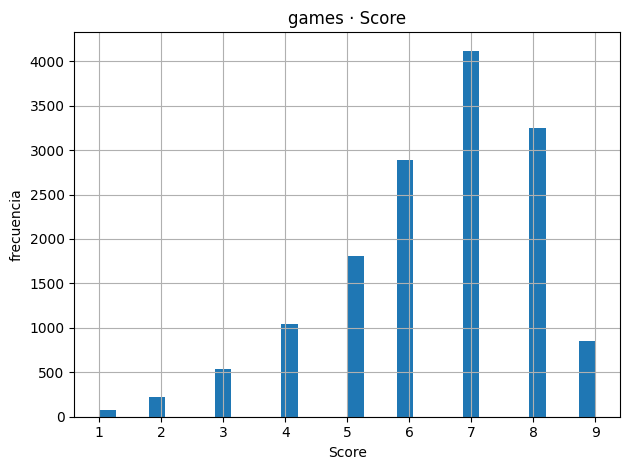

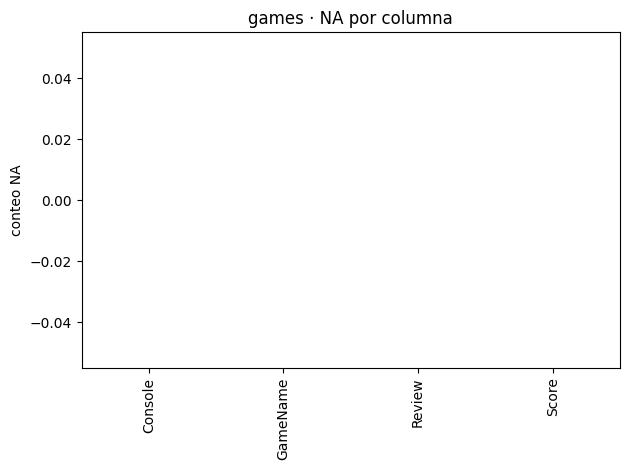

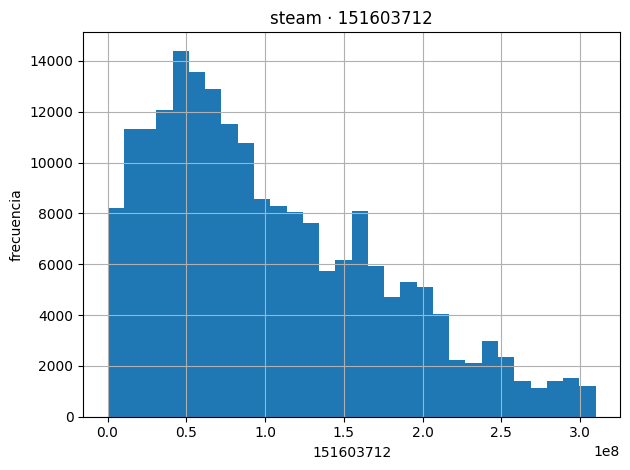

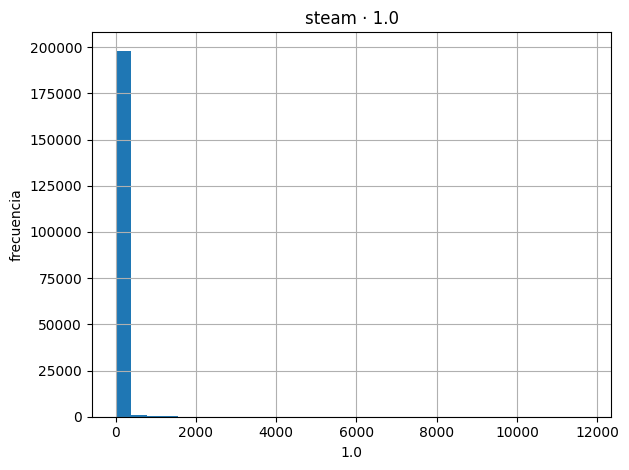

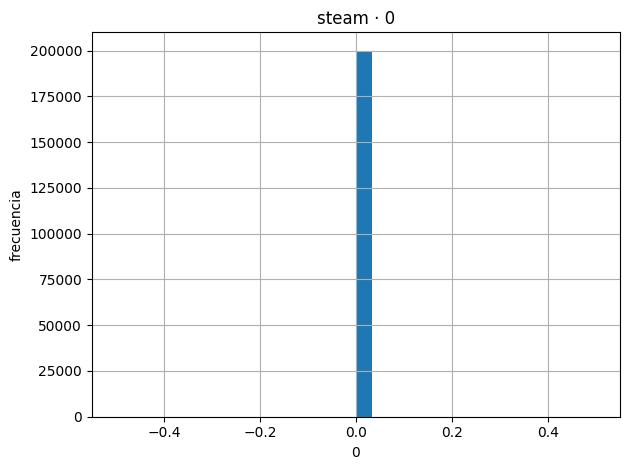

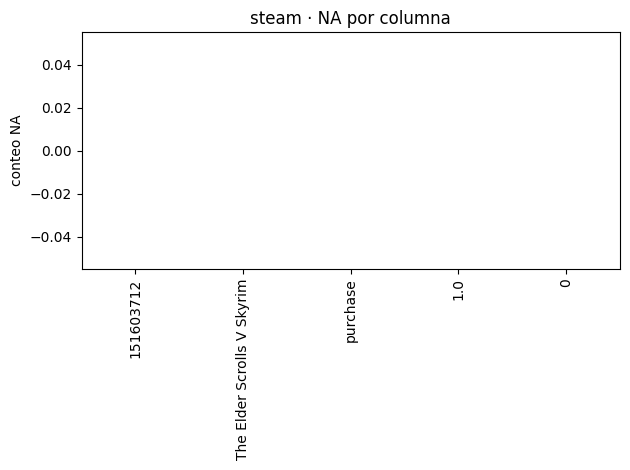

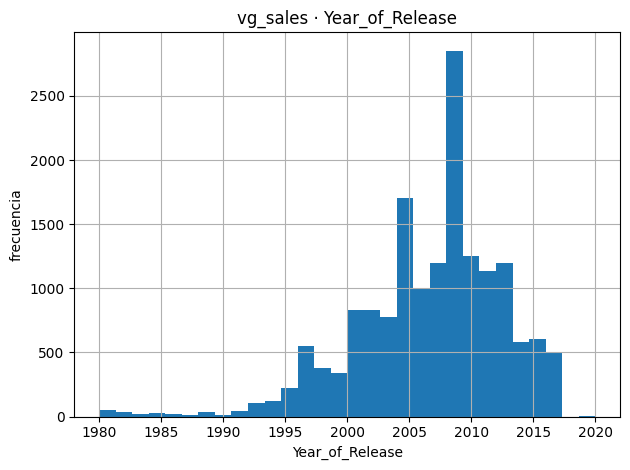

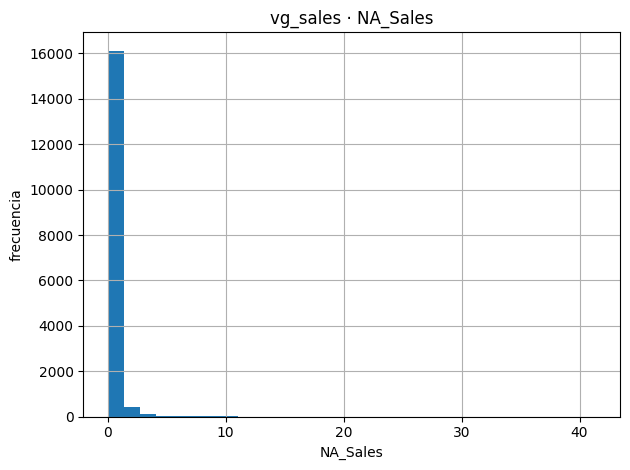

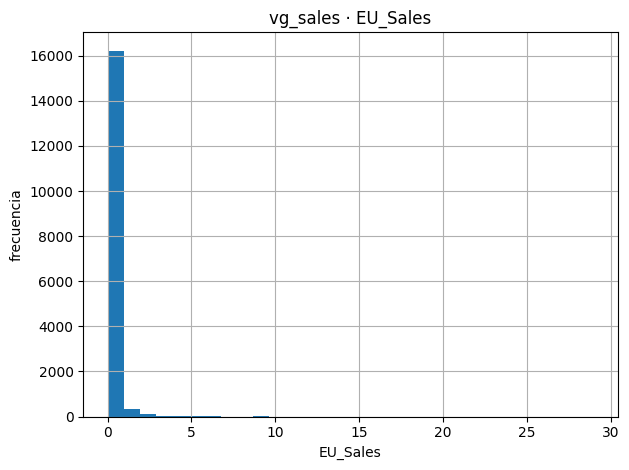

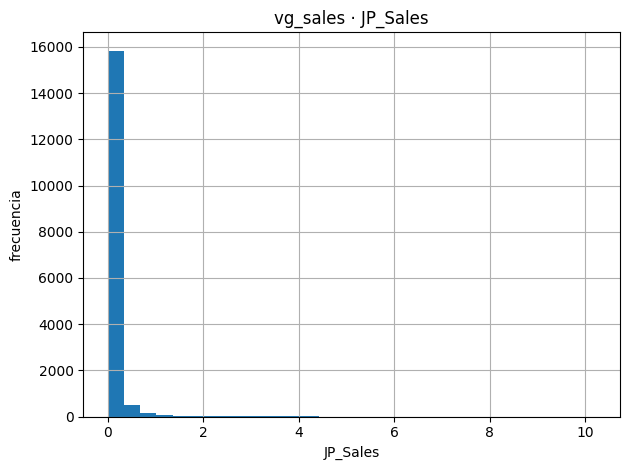

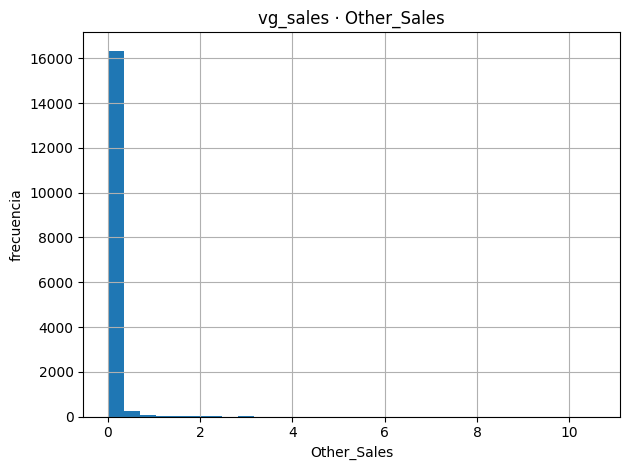

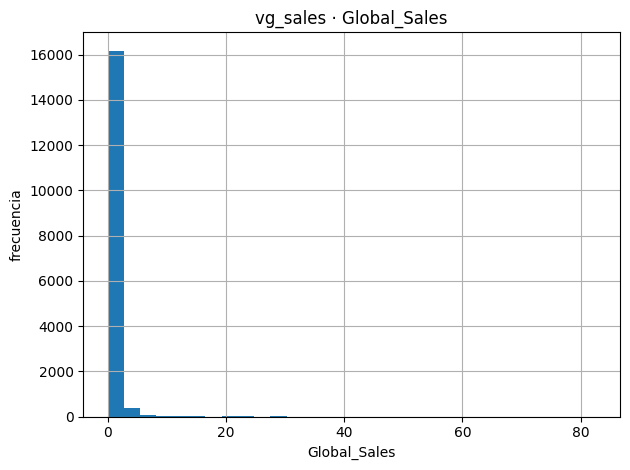

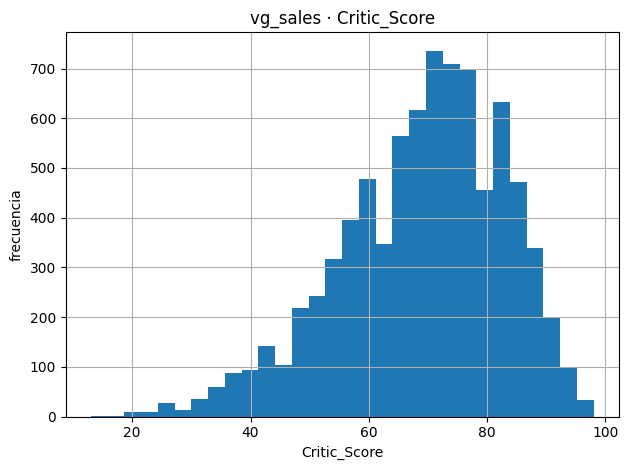

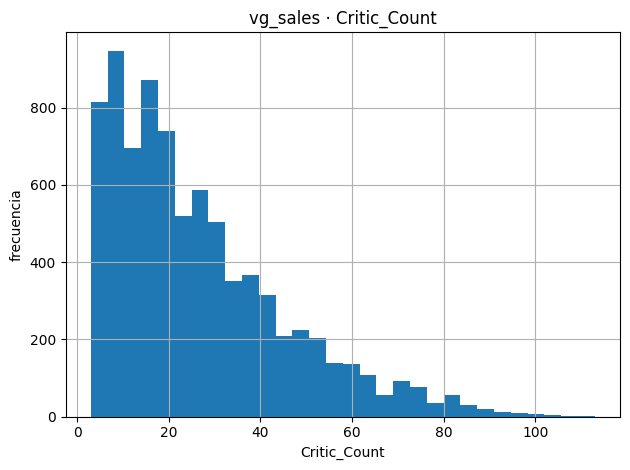

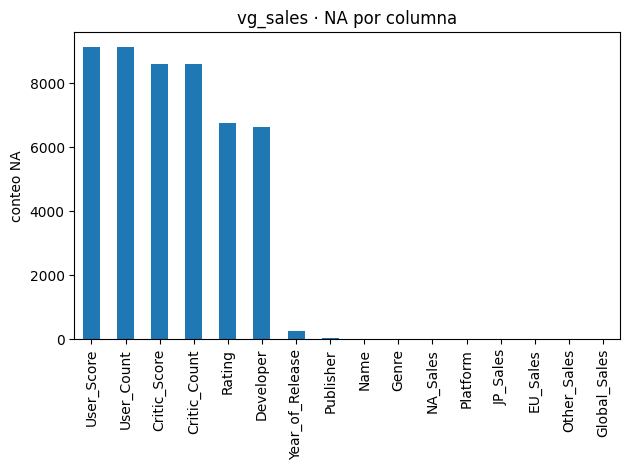

In [7]:
import matplotlib.pyplot as plt
games = load_or_build("games_raw", "data_understanding")
steam = load_or_build("steam_raw", "data_understanding")
vg = load_or_build("vg_sales_raw", "data_understanding")

def plot_numeric_hist(df, title_prefix="dataset"):
    num_cols = df.select_dtypes(include="number").columns.tolist()
    for col in num_cols[:8]:  # límite para no llenar el notebook
        plt.figure()
        df[col].dropna().hist(bins=30)
        plt.title(f"{title_prefix} · {col}")
        plt.xlabel(col); plt.ylabel("frecuencia")
        plt.tight_layout()

def plot_missing_bars(df, title="missing per column"):
    na = df.isna().sum().sort_values(ascending=False)
    plt.figure()
    na.head(20).plot(kind="bar")
    plt.title(title); plt.ylabel("conteo NA"); plt.tight_layout()

plot_numeric_hist(games, "games")
plot_missing_bars(games, "games · NA por columna")
plot_numeric_hist(steam, "steam")
plot_missing_bars(steam, "steam · NA por columna")
plot_numeric_hist(vg, "vg_sales")
plot_missing_bars(vg, "vg_sales · NA por columna")

#### Hallazgos clave y decisiones para preparación (rellena aquí)